In [1]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu

In [2]:
# Define the U-Net architecture for binary segmentation
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder (downsampling path)
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.enc_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.enc_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc_conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.enc_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.enc_conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.enc_pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck_conv1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bottleneck_conv2 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)

        # Decoder (upsampling path)
        self.dec_upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec_conv1 = nn.Conv2d(1024 + 512, 512, kernel_size=3, padding=1)
        self.dec_conv2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.dec_upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec_conv3 = nn.Conv2d(512 + 256, 256, kernel_size=3, padding=1)
        self.dec_conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.dec_upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec_conv5 = nn.Conv2d(256 + 128, 128, kernel_size=3, padding=1)
        self.dec_conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.dec_upsample4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec_conv7 = nn.Conv2d(128 + 64, 64, kernel_size=3, padding=1)
        self.dec_conv8 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

          # Output
        self.output_conv = nn.Conv2d(64, 1, kernel_size=1)  # 1x1 convolution for binary segmentation


    def forward(self, x):
        # Encoder (downsampling path)
        enc1 = nn.ReLU()(self.enc_conv1(x))
        enc2 = nn.ReLU()(self.enc_conv2(enc1))
        enc2_pool = self.enc_pool1(enc2)

        enc3 = nn.ReLU()(self.enc_conv3(enc2_pool))
        enc4 = nn.ReLU()(self.enc_conv4(enc3))
        enc4_pool = self.enc_pool2(enc4)

        enc5 = nn.ReLU()(self.enc_conv5(enc4_pool))
        enc6 = nn.ReLU()(self.enc_conv6(enc5))
        enc6_pool = self.enc_pool3(enc6)

        enc7 = nn.ReLU()(self.enc_conv7(enc6_pool))
        enc8 = nn.ReLU()(self.enc_conv8(enc7))
        enc8_pool = self.enc_pool4(enc8)

        # Bottleneck
        bottleneck = nn.ReLU()(self.bottleneck_conv1(enc8_pool))
        bottleneck = nn.ReLU()(self.bottleneck_conv2(bottleneck))

        # Decoder (upsampling path)
        dec1 = self.dec_upsample1(bottleneck)
        dec1 = torch.cat([dec1, enc8], dim=1)
        dec1 = nn.ReLU()(self.dec_conv1(dec1))
        dec1 = nn.ReLU()(self.dec_conv2(dec1))

        dec2 = self.dec_upsample2(dec1)
        dec2 = torch.cat([dec2, enc6], dim=1)
        dec2 = nn.ReLU()(self.dec_conv3(dec2))
        dec2 = nn.ReLU()(self.dec_conv4(dec2))

        dec3 = self.dec_upsample3(dec2)
        dec3 = torch.cat([dec3, enc4], dim=1)
        dec3 = nn.ReLU()(self.dec_conv5(dec3))
        dec3 = nn.ReLU()(self.dec_conv6(dec3))

        dec4 = self.dec_upsample4(dec3)
        dec4 = torch.cat([dec4, enc2], dim=1)
        dec4 = nn.ReLU()(self.dec_conv7(dec4))
        dec4 = nn.ReLU()(self.dec_conv8(dec4))

        # Output
        output = self.output_conv(dec4)
        return output   
    
    # Create an instance of the FCN model
model = UNet()

In [3]:
# Define criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [4]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])
transform_mask = transforms.Compose([
    transforms.ToTensor(),
])

In [42]:
# In this example, the CustomDataset takes in two lists of file paths: image_list and mask_list, representing the paths to the images and their corresponding masks, 
# respectively. It also takes in an optional transform argument to apply any necessary transformations to the images and masks.
class CustomDataset(Dataset):
    def __init__(self, image_list, mask_list, transform=None, transform_mask=None):
        self.image_list = [os.path.join(image_list, f) for f in os.listdir(image_list)]
        self.mask_list = [os.path.join(mask_list, f) for f in os.listdir(mask_list)]
        self.transform = transform
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = self.image_list[idx]
        mask_path = self.mask_list[idx]
        image = Image.open(image_path)
        image = image.convert('RGB')
        mask = Image.open(mask_path)
        mask = mask.convert('L')

        if self.transform:
            image = self.transform(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)


        return image, mask

In [44]:
folder_real = 'yourPathToImages'
folder_mask = 'yourPathToMasks'

data = CustomDataset(folder_real,folder_mask, transform=transform, transform_mask=transform_mask)

In [7]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

c:\Python310\lib\site-packages\torchvision\transforms.py:50: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


In [8]:
len(train_data), len(test_data), len(val_data)

(1224, 408, 408)

In [9]:
# Define the data loader
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

len_train = len(train_loader)*batch_size
len_val = len(val_loader)*batch_size

In [10]:
# Mean and STD calculations for real images
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# Data normalization only based on training set
for i, (images, labels) in enumerate(train_loader):
    psum    += images.sum(axis        = [0, 2, 3])
    psum_sq += (images ** 2).sum(axis = [0, 2, 3])
    

# Final Calculation
# Resolution of the image
image_size = 256
count = len_train * image_size * image_size

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

mean: tensor([0.4406, 0.4444, 0.3446])
std:  tensor([0.2787, 0.2783, 0.3058])


In [11]:
# Update the trasforms based on the computed mean and std
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=total_mean,
                            std=total_std)
])

transform_mask = transforms.Compose([
    transforms.ToTensor(),
])

In [12]:
# Reload data, now with normalization based on the training data
data = CustomDataset(folder_real,folder_mask, transform=transform, transform_mask=transform_mask)

# By using random seed 42 for both data splitting, it will result in the same split everytime.
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [13]:
num_epochs = 10
train_loss_list = []
valid_loss_list = []
for epoch in range(num_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    # Set the model to training mode
    model.train()
    
    # Iterate over the training data
    for i, (images, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        train_loss += loss.item()*images.size(0)
        # Print the loss every batch
        if i % 1 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    # Set the model to evaluation mode
    model.eval()
    
    # Compute the validation loss
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            # Forward pass
            outputs = model(images)
            
            # Compute the loss
            loss = criterion(outputs, labels)
            
            valid_loss += loss.item()*images.size(0)
            # Accumulate the loss over all batches
            val_loss += loss.item() * images.size(0)
    # Compute the average validation loss
    val_loss /= len(val_data)
    # Calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(val_loader.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}] , Val Loss: {val_loss:.4f}')

Epoch [1/10], Batch [1/41], Loss: 0.1593
Epoch [1/10], Batch [2/41], Loss: 0.1398
Epoch [1/10], Batch [3/41], Loss: 3149.1414
Epoch [1/10], Batch [4/41], Loss: 0.1347
Epoch [1/10], Batch [5/41], Loss: 0.1447
Epoch [1/10], Batch [6/41], Loss: 0.1480
Epoch [1/10], Batch [7/41], Loss: 0.1486
Epoch [1/10], Batch [8/41], Loss: 0.1494
Epoch [1/10], Batch [9/41], Loss: 0.1478
Epoch [1/10], Batch [10/41], Loss: 0.1479
Epoch [1/10], Batch [11/41], Loss: 0.1472
Epoch [1/10], Batch [12/41], Loss: 0.1446
Epoch [1/10], Batch [13/41], Loss: 0.1384
Epoch [1/10], Batch [14/41], Loss: 0.1150
Epoch [1/10], Batch [15/41], Loss: 0.2346
Epoch [1/10], Batch [16/41], Loss: 0.1084
Epoch [1/10], Batch [17/41], Loss: 0.1303
Epoch [1/10], Batch [18/41], Loss: 0.1394
Epoch [1/10], Batch [19/41], Loss: 0.1431
Epoch [1/10], Batch [20/41], Loss: 0.1440
Epoch [1/10], Batch [21/41], Loss: 0.1444
Epoch [1/10], Batch [22/41], Loss: 0.1442
Epoch [1/10], Batch [23/41], Loss: 0.1437
Epoch [1/10], Batch [24/41], Loss: 0.142

In [14]:
# Save data in .csv file
raw_data = {'Train_loss': train_loss_list,
            'Valid_Loss': valid_loss_list}

df = pd.DataFrame(raw_data, columns = ['Train_loss', 'Valid_Loss'])

# Always check/change name for new model
df.to_csv('pathToSaveCSV', index=True)

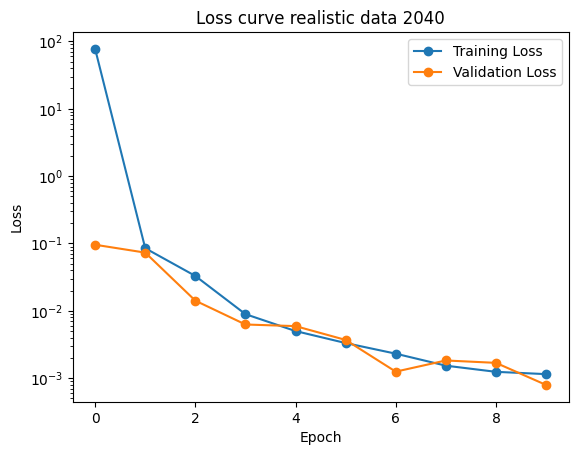

In [15]:
# Plottig Train and Val Loss
plt.plot(train_loss_list,  marker='o', label="Training Loss")
plt.plot(valid_loss_list,  marker='o', label="Validation Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss curve realistic data (nameOfDataset)')
plt.yscale('log')
plt.legend()
plt.show()

In [16]:
# Save model
torch.save(model.state_dict(), 'pathToSaveWeightsFile.pt')

In [17]:
# Load model
model = UNet()
model.load_state_dict(torch.load('pathToSaveWeightsFile.pt'))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


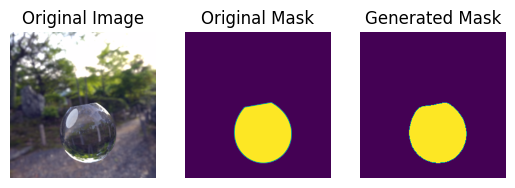

In [35]:
# This code shows an example of the generated mask based on the loaded model
import numpy as np
import matplotlib.pyplot as plt
import random
# Load random sample from test_data to check mask visually
img, label = test_data[random.randint(0, len(test_data)-1)]
img = img.unsqueeze(0)

# Assuming you have the trained model and a test image

# Set the model to evaluation mode
model.eval()

# Perform forward pass on the test image
with torch.no_grad():
    output = model(img)  # Assuming you have the test image as a tensor
# Convert the output tensor to a numpy array and squeeze the batch and channel dimensions
output_np = output.squeeze(0).squeeze(0).cpu().numpy()
# Apply a threshold to convert the output to a binary mask
threshold_value =  threshold_otsu(output_np)
mask = (output_np >= threshold_value).astype(np.float32)

# Invert the origial transform of the loaded tesor
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = 1/total_std),
                                transforms.Normalize(mean = -total_mean,
                                                     std = [ 1., 1., 1. ]),
                               ])
inv_tensor = invTrans(img)

# Compute right order of tensor for plots
img = inv_tensor.permute(0, 2, 3, 1)
label = label.permute(1, 2, 0)

# Reshape the tensor
img = img.reshape(256, 256, 3)
label = label.reshape(256, 256, 1)

# Plot the original test image
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Plot the original mask
plt.subplot(1, 3, 2)
plt.imshow(label)
plt.title('Original Mask')
plt.axis('off')

# Plot the generated mask
plt.subplot(1, 3, 3)
plt.imshow(mask)
plt.title('Generated Mask')
plt.axis('off')

plt.show()